# Test if we can load trained weights - make modifications to the model class (to save intermediated feature maps) needed for analysis

TLDR: yes it works !

# Load libraries 

In [1]:
# %%bash
# pip install attrdict
# pip install timm
# pip install pytorch-lightning==1.4.0

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import os
import tqdm

import seaborn as sns
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.utils import make_grid
from attrdict import AttrDict
import torch
import yaml
from sklearn.model_selection import StratifiedKFold
import copy
import pickle
# from tqdm import tqdm_notebook

# additional lightning 

import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import LightningDataModule, LightningModule


# pytorch
import torch
from torch import nn
import torch.nn.functional as F
from timm import create_model


from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Resnet

In [4]:
# https://stackoverflow.com/questions/36700404/tensorflow-opening-log-data-written-by-summarywriter

resnet_list = []
for i in range(5):
    print(f"\n Fold: {i}==================================================")
    path = [x for x in os.listdir(f"../input/02-pytorch-lightning-variant/pawnet_lightning_resnet/default/version_{i}/") if x.startswith("events")][0]
    event_acc = EventAccumulator(os.path.join(f"../input/02-pytorch-lightning-variant/pawnet_lightning_resnet/default/version_{i}/",path), size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]
    resnet_list.append(scalars)

In [5]:
resnet_val = 0
resnet_training_curve = []
resnet_validation_curve = []
for f in resnet_list:
    print(f["val_RMSE_loss"][-1])
    resnet_val +=f["val_RMSE_loss"][-1] / 5
print(f"AVG: {resnet_val}")

# Efficient net 


In [5]:
# https://stackoverflow.com/questions/36700404/tensorflow-opening-log-data-written-by-summarywriter

ef_list = []
for i in range(5):
    print(f"\n Fold: {i}==================================================")
    path = [x for x in os.listdir(f"pawnet_lightning_efficientnet_b0/default/version_{i}/") if x.startswith("events")][0]
    event_acc = EventAccumulator(os.path.join(f"pawnet_lightning_efficientnet_b0/default/version_{i}/",path), size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]
    ef_list.append(scalars)


 Fold: 0==================================================

 Fold: 1==================================================

 Fold: 2==================================================

 Fold: 3==================================================

 Fold: 4==================================================


In [6]:
eff_val = 0
for f in ef_list:
    print(f["val_RMSE_loss"][-1])
    eff_val +=f["val_RMSE_loss"][-1] / 5
print(f"AVG: {eff_val}")

19.07743263244629
19.221006393432617
18.98494529724121
19.178285598754883
18.730567932128906
AVG: 19.03844757080078


# Densenet

In [8]:
# https://stackoverflow.com/questions/36700404/tensorflow-opening-log-data-written-by-summarywriter

dense_list = []
for i in range(5):
    print(f"\n Fold: {i}==================================================")
    path = [x for x in os.listdir(f"pawnet_lightning_densenet/default/version_{i}/") if x.startswith("events")][0]
    event_acc = EventAccumulator(os.path.join(f"pawnet_lightning_densenet/default/version_{i}/",path), size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]
    dense_list.append(scalars)


 Fold: 0==================================================

 Fold: 1==================================================

 Fold: 2==================================================

 Fold: 3==================================================

 Fold: 4==================================================


In [9]:
dense_val = 0
for f in dense_list:
    print(f["val_RMSE_loss"][-1])
    dense_val +=f["val_RMSE_loss"][-1] / 5
print(f"AVG: {dense_val}")

19.015472412109375
19.3493595123291
19.117677688598633
18.702354431152344
18.300996780395508
AVG: 18.89717216491699


# Vit

In [7]:
# https://stackoverflow.com/questions/36700404/tensorflow-opening-log-data-written-by-summarywriter

vit_list = []
for i in range(5):
    print(f"\n Fold: {i}==================================================")
    path = [x for x in os.listdir(f"../input/../input/vit-small/pawnet_lightning_vit_tiny_patch16_224/default/version_{i}/") if x.startswith("events")][0]
    event_acc = EventAccumulator(os.path.join(f"../input/vit-small/pawnet_lightning_vit_tiny_patch16_224/default/version_{i}/",path), size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]
    vit_list.append(scalars)

In [8]:
vit_val = 0
for f in vit_list:
    print(f["val_RMSE_loss"][-1])
    vit_val +=f["val_RMSE_loss"][-1] / 5
print(f"AVG: {vit_val}")

# Swin

In [12]:
# ! gsutil cp -r gs://pawnet/2d-swin_tiny/* .

Copying gs://pawnet/2d-swin_tiny/pawnet_lightning_swin_tiny4_w7_224/default/version_0/events.out.tfevents.1638102537.torch.5395.0...
Copying gs://pawnet/2d-swin_tiny/pawnet_lightning_swin_tiny4_w7_224/default/version_0/hparams.yaml...
Copying gs://pawnet/2d-swin_tiny/pawnet_lightning_swin_tiny4_w7_224/default/version_1/checkpoints/best_loss.ckpt...
Copying gs://pawnet/2d-swin_tiny/pawnet_lightning_swin_tiny4_w7_224/default/version_1/checkpoints/last.ckpt...
- [4 files][650.0 MiB/650.0 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://pawnet/2d-swin_tiny/pawnet_lightning_swin_tiny4_w7_224/default/version_1/events.out.tfevents.1638102912.torch.5395.1...
Copying gs://pawnet/2d-swin_tiny/pawnet_lightning_swin_tiny4_w7_224/defa

In [25]:
# https://stackoverflow.com/questions/36700404/tensorflow-opening-log-data-written-by-summarywriter

swin_base_list = []
for i in range(1,6):
    print(f"\n Fold: {i}==================================================")
    path = [x for x in os.listdir(f"pawnet_lightning_swin_tiny4_w7_224/default/version_{i}/") if x.startswith("events")][0]
    event_acc = EventAccumulator(os.path.join(f"pawnet_lightning_swin_tiny4_w7_224/default/version_{i}/",path), size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]
    swin_base_list.append(scalars)


 Fold: 1==================================================

 Fold: 2==================================================

 Fold: 3==================================================

 Fold: 4==================================================

 Fold: 5==================================================


In [27]:
swin_val = 0
count = 0
for f in swin_base_list:
    print(f["val_RMSE_loss"][-1])
    swin_val +=f["val_RMSE_loss"][-1] / 5
print(f"AVG: {swin_val}")

18.600101470947266
18.901531219482422
18.20035171508789
18.23086166381836
18.08286476135254
AVG: 18.403142166137698


# Swin + advance augmentation 

In [3]:
# https://stackoverflow.com/questions/36700404/tensorflow-opening-log-data-written-by-summarywriter

swin_aug_list = []
for i in range(5):
    print(f"\n Fold: {i}==================================================")
    path = [x for x in os.listdir(f"pawnet_lightning_swin_tiny4_w7_224/default/version_{i}/") if x.startswith("events")][0]
    event_acc = EventAccumulator(os.path.join(f"pawnet_lightning_swin_tiny4_w7_224/default/version_{i}/",path), size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]
    swin_aug_list.append(scalars)


 Fold: 0==================================================

 Fold: 1==================================================

 Fold: 2==================================================

 Fold: 3==================================================

 Fold: 4==================================================


In [4]:
swin_aug_val = 0
for f in swin_aug_list:
    print(f["val_RMSE_loss"][-1])
    swin_aug_val +=f["val_RMSE_loss"][-1] / 5
print(f"AVG: {swin_aug_val}")

18.415483474731445
18.863725662231445
18.313405990600586
18.262056350708008
18.002239227294922
AVG: 18.37138214111328


# Swin + mixup alpha = 0.2

In [10]:
# https://stackoverflow.com/questions/36700404/tensorflow-opening-log-data-written-by-summarywriter

swin_m02_list = []
for i in range(5):
    print(f"\n Fold: {i}==================================================")
    path = [x for x in os.listdir(f"pawnet_lightning_swin_tiny4_w7_224_mixup02/default/version_{i}/") if x.startswith("events")][0]
    event_acc = EventAccumulator(os.path.join(f"pawnet_lightning_swin_tiny4_w7_224_mixup02/default/version_{i}/",path), size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]
    swin_m02_list.append(scalars)


 Fold: 0==================================================

 Fold: 1==================================================

 Fold: 2==================================================

 Fold: 3==================================================

 Fold: 4==================================================


In [11]:
swin_m02_val = 0
for f in swin_m02_list:
    print(f["val_RMSE_loss"][-1])
    swin_m02_val +=f["val_RMSE_loss"][-1] / 5
print(f"AVG: {swin_m02_val}")

18.29349136352539
18.562191009521484
18.283353805541992
18.57217788696289
18.08156967163086
AVG: 18.358556747436523


# Swin + mixup alpha = 0.4

In [12]:
# https://stackoverflow.com/questions/36700404/tensorflow-opening-log-data-written-by-summarywriter

swin_m04_list = []
for i in range(5):
    print(f"\n Fold: {i}==================================================")
    path = [x for x in os.listdir(f"pawnet_lightning_swin_tiny4_w7_224_mixup04/default/version_{i}/") if x.startswith("events")][0]
    event_acc = EventAccumulator(os.path.join(f"pawnet_lightning_swin_tiny4_w7_224_mixup04/default/version_{i}/",path), size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]
    swin_m04_list.append(scalars)


 Fold: 0==================================================

 Fold: 1==================================================

 Fold: 2==================================================

 Fold: 3==================================================

 Fold: 4==================================================


In [13]:
swin_m04_val = 0
for f in swin_m04_list:
    print(f["val_RMSE_loss"][-1])
    swin_m04_val +=f["val_RMSE_loss"][-1] / 5
print(f"AVG: {swin_m04_val}")

18.30559539794922
18.60878562927246
18.12067222595215
18.248369216918945
18.02658462524414
AVG: 18.262001419067385


# Swin Large + mixup alpha 0.4

In [27]:
# https://stackoverflow.com/questions/36700404/tensorflow-opening-log-data-written-by-summarywriter
swinl_m04_list = []
for i in range(5,10):
    print(f"\n Fold: {i}==================================================")
    path = [x for x in os.listdir(f"pawnet_lightning_swin_large4_w7_224_mixup04/default/version_{i}/") if x.startswith("events")][0]
    event_acc = EventAccumulator(os.path.join(f"pawnet_lightning_swin_large4_w7_224_mixup04/default/version_{i}/",path), size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]
    swinl_m04_list.append(scalars)


 Fold: 5==================================================

 Fold: 6==================================================

 Fold: 7==================================================

 Fold: 8==================================================

 Fold: 9==================================================


In [4]:
swinl_m04_val = 0
for f in swinl_m04_list:
    print(f["val_RMSE_loss"][-1])
    swinl_m04_val +=f["val_RMSE_loss"][-1] / 5
print(f"AVG: {swinl_m04_val}")

18.111711502075195
18.313365936279297
17.86671257019043
17.790376663208008
17.887571334838867
AVG: 17.99394760131836


# Swin + cutmix 

In [2]:
# https://stackoverflow.com/questions/36700404/tensorflow-opening-log-data-written-by-summarywriter

swin_cut1_list = []
for i in range(5):
    print(f"\n Fold: {i}==================================================")
    path = [x for x in os.listdir(f"pawnet_lightning_swin_tiny4_w7_224_cutmix1/default/version_{i}/") if x.startswith("events")][0]
    event_acc = EventAccumulator(os.path.join(f"pawnet_lightning_swin_tiny4_w7_224_cutmix1/default/version_{i}/",path), size_guidance={'scalars': 0})
    event_acc.Reload()

    scalars = {}
    for tag in event_acc.Tags()['scalars']:
        events = event_acc.Scalars(tag)
        scalars[tag] = [event.value for event in events]
    swin_cut1_list.append(scalars)


 Fold: 0==================================================

 Fold: 1==================================================

 Fold: 2==================================================

 Fold: 3==================================================

 Fold: 4==================================================


In [3]:
swin_cut1_val = 0
for f in swin_cut1_list:
    print(f["val_RMSE_loss"][-1])
    swin_cut1_val +=f["val_RMSE_loss"][-1] / 5
print(f"AVG: {swin_cut1_val}")

18.255319595336914
18.685256958007812
18.37305450439453
18.21916961669922
17.705501556396484
AVG: 18.247660446166993


# Visualize all

NameError: name 'resnet_list' is not defined

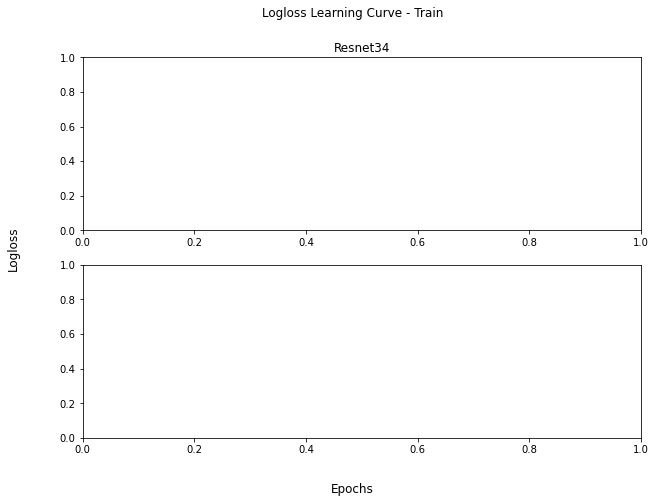

In [4]:
fig,axes = plt.subplots(nrows=2, figsize=(10,7))
fig.suptitle('Logloss Learning Curve - Train')
fig.supxlabel('Epochs')
fig.supylabel('Logloss')

axes[0].set_title("Resnet34")
axes[0].plot(np.arange(len(resnet_list[0]["train_logloss"])),resnet_list[0]["train_logloss"])
axes[0].plot(np.arange(len(resnet_list[1]["train_logloss"])),resnet_list[1]["train_logloss"])
axes[0].plot(np.arange(len(resnet_list[2]["train_logloss"])),resnet_list[2]["train_logloss"])
axes[0].plot(np.arange(len(resnet_list[3]["train_logloss"])),resnet_list[3]["train_logloss"])
axes[0].plot(np.arange(len(resnet_list[4]["train_logloss"])),resnet_list[4]["train_logloss"])
axes[0].grid()

axes[1].set_title("Vit-Tiny-224")
axes[1].plot(np.arange(len(vit_list[0]["train_logloss"])),vit_list[0]["train_logloss"])
axes[1].plot(np.arange(len(vit_list[1]["train_logloss"])),vit_list[1]["train_logloss"])
axes[1].plot(np.arange(len(vit_list[2]["train_logloss"])),vit_list[2]["train_logloss"])
axes[1].plot(np.arange(len(vit_list[3]["train_logloss"])),vit_list[3]["train_logloss"])
axes[1].plot(np.arange(len(vit_list[4]["train_logloss"])),vit_list[4]["train_logloss"])
axes[1].grid()

In [14]:
fig,axes = plt.subplots(nrows=2, figsize=(10,7))
fig.suptitle('RMSE Learning Curve - Validation')
fig.supxlabel('Epochs')
fig.supylabel('RMSE')

axes[0].set_title("Resnet34")
axes[0].plot(np.arange(len(resnet_list[0]["val_RMSE_loss"])),resnet_list[0]["val_RMSE_loss"])
axes[0].plot(np.arange(len(resnet_list[1]["val_RMSE_loss"])),resnet_list[1]["val_RMSE_loss"])
axes[0].plot(np.arange(len(resnet_list[2]["val_RMSE_loss"])),resnet_list[2]["val_RMSE_loss"])
axes[0].plot(np.arange(len(resnet_list[3]["val_RMSE_loss"])),resnet_list[3]["val_RMSE_loss"])
axes[0].plot(np.arange(len(resnet_list[4]["val_RMSE_loss"])),resnet_list[4]["val_RMSE_loss"])
axes[0].grid()

axes[1].set_title("Vit-Tiny-224")
axes[1].plot(np.arange(len(vit_list[0]["val_RMSE_loss"])),vit_list[0]["val_RMSE_loss"])
axes[1].plot(np.arange(len(vit_list[1]["val_RMSE_loss"])),vit_list[1]["val_RMSE_loss"])
axes[1].plot(np.arange(len(vit_list[2]["val_RMSE_loss"])),vit_list[2]["val_RMSE_loss"])
axes[1].plot(np.arange(len(vit_list[3]["val_RMSE_loss"])),vit_list[3]["val_RMSE_loss"])
axes[1].plot(np.arange(len(vit_list[4]["val_RMSE_loss"])),vit_list[4]["val_RMSE_loss"])
axes[1].grid()